<pre><div style="text-align:center">Shon Otmazgin    Sapir Rubin</div></pre>

### Abstract
Supervised learning has been widely used to detect anomaly in credit card transaction records based on the assumption that the pattern of a fraud would depend on the past transaction. However, unsupervised learning does not ignore the fact that the fraudsters could change their approaches based on customers’ behaviors and patterns. in this study we will present iterative  method of using mixture of gussians to detect anomaly in credit card transactions. We will compare it with iterative method using OneClassSVM. 
In each method our algorithm utilizes the model functions(likelihood and shifted from support vector) scores, evaluates samples with thier scores and samples score under threshold T consider to be anomalies. the described method is iterative until model converges or max iteration exceeds.
The dataset used in this study is based on real-life data of credit card transaction. Due to the availability of the response(labels), after training the models we can evaluate the performance of each model. The performance of these two methods is discussed extensively in this paper.

### Dataset 
The dataset that is used for credit card fraud detection is derived from the following [URL](https://eur02.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdata.world%2Fraghu543%2Fcredit-card-fraud-data&amp;data=02%7C01%7CYael.Madar%40biu.ac.il%7Cb48189911f224aef8c2e08d79ff0c5e6%7C61234e145b874b67ac198feaa8ba8f12%7C0%7C0%7C637153728776732928&amp;sdata=tzNpfPA2qlY12Dp1Zli5FW5ugw0Q05OaTCay5mAvo4c%3D&amp;reserved=0)

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly imbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, there are not provided the original features and more background information about the data.
It contains only numerical input variables which are the result of a PCA transformation.

- Features V1, V2, ... V28 are the principal components obtained with PCA;
- The only features which have not been transformed with PCA are Time and Amount.
 - Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset.
 - The feature Amount is the transaction Amount.
- Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Problem Statement Task:

The Credit Card Fraud Detection Problem includes past credit card transactions. The need is to identify whether a new transaction is fraudulent or not. The data is higly imbalanced and our aim here is to detect the fraudulent transactions while minimizing the incorrect fraud classifications.
Let's realize that we are looking for a needle in a hay barn. 99% of the data are valid transactions. We could balance the data by oversampling or undersampling and even to fit the models with only valid transactions, but we want our models to be able to produce results in the real world and not just in testing environment, <u>therefore we will develop our model as like labels was not existed.</u> This is why we should use the imbalanced data, in order to better simulate real world cases. If our model can identify even a fraction of fraud cases with high precision, it is adding value.

#### Load packages

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc

RANDOM_STATE = 42

### Data Exploration and visualization

In [2]:
df = pd.read_csv("../dataset/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

#### Check missing data

In [6]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

#### Class Distribution

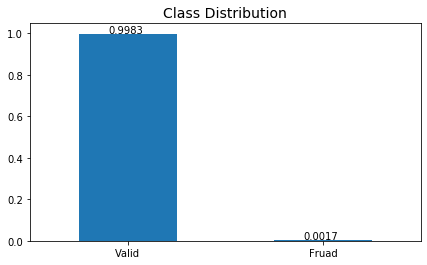

In [7]:
ax = df['Class'].value_counts(normalize=True).plot(kind='bar',  figsize=(7,4))
for i, v in enumerate(df['Class'].value_counts(normalize=True).values):
    ax.text(i - 0.1, v + 0.005, str(round(v, 4)))
ax.set_xticklabels(['Valid', 'Fruad'],rotation=0)
ax.set_title('Class Distribution', fontsize=14)

plt.show()

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly imbalanced with respect with target variable Class.  

#### Transactions Time and Amount Distributions

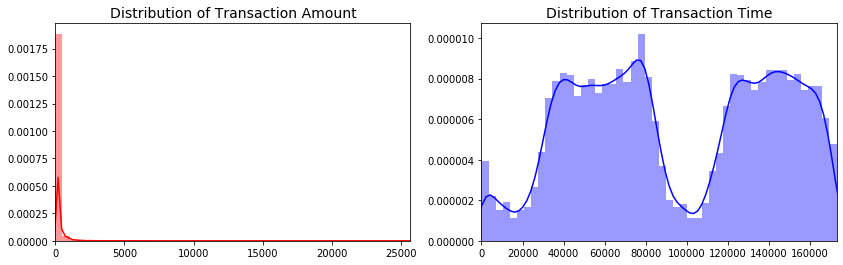

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

- Most transactions are small amounts transactions, less than $100.
- Clearly, it looks like there are cycles in Time.

#### Transactions Time and Amount Distributions by Class

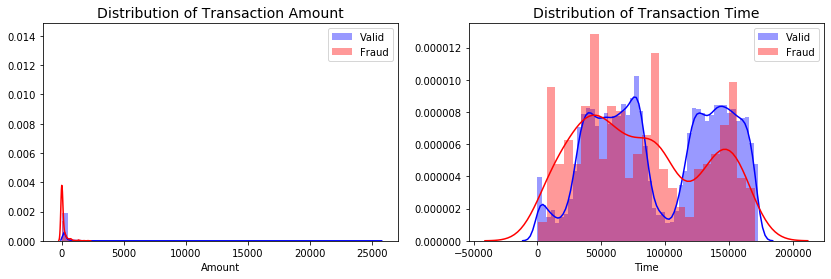

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

time_class_0 = df.loc[df['Class'] == 0]["Time"]
time_class_1 = df.loc[df['Class'] == 1]["Time"]
amount_class_0 = df.loc[df['Class'] == 0]["Amount"]
amount_class_1 = df.loc[df['Class'] == 1]["Amount"]

sns.distplot(amount_class_0, ax=ax[0], color='b' ,hist=True, label='Valid')
sns.distplot(amount_class_1, ax=ax[0], color='r' ,hist=True, label='Fraud')

sns.distplot(time_class_0, ax=ax[1], color='b' ,hist=True, label='Valid')
sns.distplot(time_class_1, ax=ax[1], color='r' ,hist=True, label='Fraud', bins=25)

ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[0].legend()
ax[1].legend()
plt.show()

- The 'Time' feature looks pretty similar across both types of transactions. You could argue that fraudulent transactions are more uniformly distributed, while valid transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.
- Most transactions are small amounts, less than $100. Fraudulent transactions have a maximum value far less than normal transactions, 2K vs 25k.

Now let's see if the transaction amount differs between the two types.

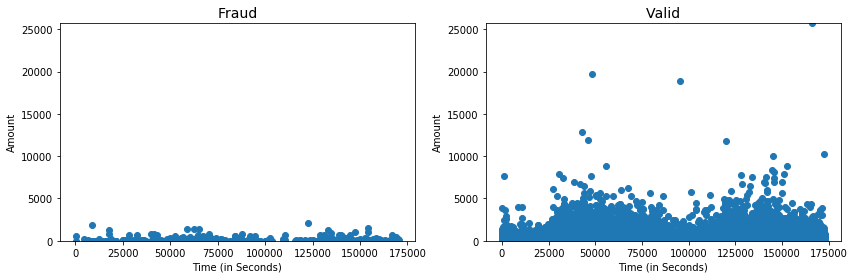

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud', fontsize=14)
ax1.set_ylim([min(amount_val), max(amount_val)])
ax1.set_ylabel('Amount')
ax1.set_xlabel('Time (in Seconds)')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Valid', fontsize=14)
ax2.set_ylim([min(amount_val), max(amount_val)])
ax2.set_ylabel('Amount')
ax2.set_xlabel('Time (in Seconds)')

plt.show()

Both types equally distributed over time. y-axis is signiffly different between fraud and valid transactions.  

**Reminder** - Unsupervised Learning is a process of training a machine learning model on a dataset in which target variable is unknown.  we will develop our model as like labels was not existed.

### Scaling
In this phase of our paper, we will scale the columns comprise of Time and Amount . Time and Amount should be scaled as the other columns already scaled through the PCA transformation.
We will use Robust Scaler, Scale features using statistics that are robust to outliers.

In [11]:
scaled_df = df.drop(columns=['Class'])
scaled_df['Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
scaled_df['Time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))
scaled_df['Class'] = df['Class']

#### Split the Data to 80% Train and 20% Test

In [12]:
train_df, test_df = train_test_split(scaled_df, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
### This is just to save time during training.
train_df = train_df.sample(frac=0.2 , random_state=RANDOM_STATE)
test_df = test_df.sample(frac=0.2 , random_state=RANDOM_STATE)

X = train_df.drop(columns=['Class'], axis=1).reset_index(drop=True)
y = train_df['Class'].reset_index(drop=True)
X_test = test_df.drop(columns=['Class'], axis=1).reset_index(drop=True)
y_test = test_df['Class'].reset_index(drop=True)

print(f'Train size: {X.shape}')
print(f'Test size: {X_test.shape}')

Train size: (45569, 30)
Test size: (11392, 30)


### Mixture of Gaussians

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.
We are assuming that these data are Gaussian and we want to find parameters that maximize the likelihood of observing these data. In other words, we regard each point as being generated by a mixture of Gaussians and can compute that probability.

Assumning number of $K$ Gaussian distributions and $n$ data observations.  
Our unknown parameters are:
$\theta = \{\mu_1,\ldots,\mu_K,\sigma_1,\ldots,\sigma_K,\pi_1,\ldots,\pi_K\} \tag{1}$
Likelihood:
$L(\theta | X_1,\ldots,X_n) = \prod_{i=1}^n \sum_{k=1}^K \pi_k N(x_i;\mu_k, \sigma_k^2) \tag{2}$
So our log-likelihood is:
$\ell(\theta) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k N(x_i;\mu_k, \sigma_k^2) \right ) \tag{3}$
The log-likelihood is without closed-form solutions, hence solving with EM algorithm.  
Define latent variables $Z_i$:  
$Z_i \in \{1,\ldots,K\}$ is the latent variable representing the mixture component for $X_i$  
Intuitively, the latent variables $Z_i$ should help us find the MLEs. We first attempt to compute the posterior distribution of $Z_i$ given the observations:  

$P(Z_i=k|X_i) = \frac{P(X_i|Z_i=k)P(Z_i=k)}{P(X_i)} = \frac{\pi_k N(\mu_k,\sigma_k^2)}{\sum_{k=1}^K\pi_k N(\mu_k, \sigma_k)} = \gamma_{Z_i}(k) \tag{4}$

the derivative of the log-likelihood with respect to each unknown parameters:

$\hat{\mu_k} = \frac{\sum_{i=1}^n \gamma_{z_i}(k)x_i}{\sum_{i=1}^n \gamma_{z_i}(k)} = \frac{1}{N_k} \sum_{i=1}^n \gamma_{z_i}(k)x_i \tag{5}$  
$\begin{align}
\hat{\sigma_k^2} &= \frac{1}{N_k}\sum_{i=1}^n \gamma_{z_i}(k) (x_i - \mu_k)^2 \tag{6} \\
\hat{\pi_k} &= \frac{N_k}{n} \tag{7}
\end{align}$

### Selecting  GMM number of components

#### Bayesian information criterion (BIC)
This criterion gives us an estimation how good is the GMM in terms of predicting the data we actually have.  
The lower is the BIC, the better is the model to actually predict the data we have, and by extension, the true, unknown, distribution. 
When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting.  
BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model
In order to avoid overfitting, this technique penalizes models with big number of clusters.  

$BIC= ln(n)K - 2ln(\hat L) \tag{1}$

#### Silhouette score
This score consider two measures:
- $a(i)$ - The mean distance between a sample and all other points in the same cluster.
- $b(i)$ - The mean distance between a sample and all other points in the next nearest cluster.  

i.e. it checks how much the clusters are compact and well separated. The more the score is near to one, the better the clustering is.  



$\large s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}} \tag{2}$


Since we already know that the fitting procedure is not deterministic, we ran twenty fits for each number of clusters 2 to 10, then we consider the mean value and the standard deviation of the runs.  
The results are:

In [14]:
n_clusters=np.arange(2, 11)
iterations=20
n_init = 2

In [15]:
%%time
gmm_clfs = {} # dict for clf with n componnents and clf iterations
for n in n_clusters:
    print(f'fitting {n} clusters')
    clfs = []
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=n_init, covariance_type='full').fit(X) 
        clfs.append(gmm)
    gmm_clfs[n] = clfs

fitting 2 clusters
fitting 3 clusters
fitting 4 clusters
fitting 5 clusters
fitting 6 clusters
fitting 7 clusters
fitting 8 clusters
fitting 9 clusters
fitting 10 clusters
Wall time: 1h 36min 35s


In [16]:
%%time
bics=[]
bics_err=[]
sils=[]
sils_err=[]
for n in n_clusters:
    tmp_bic=[]
    tmp_sil=[]
    for i in range(iterations):
        gmm=gmm_clfs[n][i] 
        labels=gmm.predict(X)
        
        sil=silhouette_score(X, labels, metric='euclidean')
        bic=gmm.bic(X)
        
        tmp_bic.append(bic)
        tmp_sil.append(sil)
    bics.append(np.mean(tmp_bic))
    bics_err.append(np.std(tmp_bic))
    sils.append(np.mean(tmp_sil))
    sils_err.append(np.std(tmp_sil))

Wall time: 1h 25min 51s


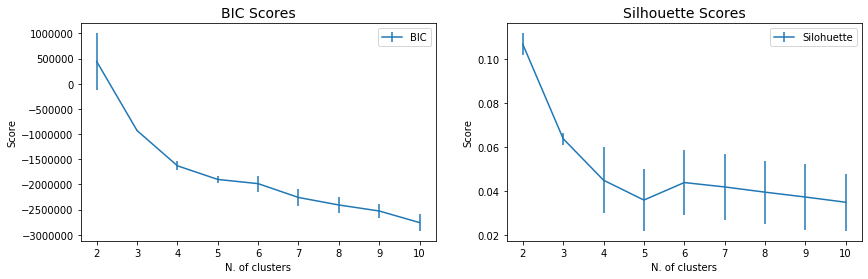

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

ax1.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
ax1.set_title("BIC Scores", fontsize=14)
ax1.set_ylabel("Score")
ax1.set_xlabel("N. of clusters")
ax1.legend()

ax2.errorbar(n_clusters, sils, yerr=sils_err, label='Silohuette')
ax2.set_title("Silhouette Scores", fontsize=14)
ax2.set_ylabel("Score")
ax2.set_xlabel("N. of clusters")
ax2.legend()

plt.show()

#### Silhouette score
WE can see the the bigger the number of clusters the higher standard deviation.
It turns out that we get the best score with 2 clusters. Also 3 clusters can be a candidate. if we consider the standard deviation (the ‘error’) of both configurations and the scores, 2 clusters is the selected.

#### BIC score
We can notice two things. The first is that the curve is fairly smooth and monotone. The second is that the curve follows different slopes in different part of it.
Following this criterion, the bigger the number of clusters, the better should be the model. Which means that the penalty BIC gives to complex models, do not save us from overfit.

Selected 2 clusters as Silhouette score recommended. 

#### Terms:
- True Positives: Correctly Classified Fraud Transactions  
- False Positives: Incorrectly Classified Fraud Transactions
- True Negative: Correctly Classified Non-Fraud Transactions
- False Negative: Incorrectly Classified Non-Fraud Transactions

#### Introduce Precision, Recall and F1 scores:  
- Precision: $p=\frac{TP}{TP + FP}$
- Recall: $r=\frac{TP}{TP + FN}$
- Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.
- Precision/Recall Tradeoff: The more precise (selective) our model is, the less cases it will detect.
- $F_1$ score: $F_1=\frac{2pr}{p+r}$ The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

all possible thresholds:
$TS = [\ \ell(s|\theta)\ |\ s\ \in\ X] \tag{1}$
Selected threshold for log likelihood:  
$T = TS[\smash{\displaystyle\argmax_{i}} F_1] \tag{2}$

In other words the threshold selected is the where $F_1$ score reach the maximum.

### Iterative approch:
1. Fit model using classifier $C1$ with data $X$
2. $F$ = $\{s \in X \ |\ \ell(s|\theta) <= T\}$
3. Fit model using classifier $C2$ with data $X-F$
4. If $C1 == C2$ stop and call converged
5. Keep doing till converged or reached to I iterations

In [32]:
def get_curve_metrics(clf, X, y):
    """
    input: clf Classifier, X Dataset, y Class labels
    calculte precision, recall, f1 and threshold for each point in the precision-recall curve
    return: tuple(precisions, recalls, f1_scores, thresholds)
    Note: clf must implement 'score_samples' method.
    """
    scores = clf.score_samples(X)
    precisions, recalls, thresholds = precision_recall_curve(y, -1 * scores)
    f1_scores = [ 2*r*p/(r+p) 
                 if r+p > 0 
                 else 0 
                 for r,p in zip(recalls, precisions) ]    
    return precisions, recalls, f1_scores, -thresholds

def f1_max_threshold(precisions, recalls, f1_scores, thresholds):
    """
    input: list of precision, list of recall, list of f1_scores, list of thresholds
    calculte threshold based on max f1_score.
    return: tuple(threshold, f1, precision, recall) at max f1_score
    """
    t = thresholds[np.argmax(f1_scores)]
    p = precisions[np.argmax(f1_scores)]
    r = recalls[np.argmax(f1_scores)]
    f1 = np.max(f1_scores)
    
    return t, p, r, f1

def plot_recall_precision_curve_samples_scores(clf, X, y, clf_name):
    """
    input: clf Classifier, X Dataset, y Class labels and Classifier name
    calculte plotting the precision-recall curve and the plotting score for each sample in X
    Note: clf must implement 'score_samples' method.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    precisions, recalls, f1_scores, thresholds = get_curve_metrics(clf, X, y)
    t, p, r, f1 = f1_max_threshold(precisions, recalls, f1_scores, thresholds)
    area = auc(recalls, precisions)

    ax1.plot(recalls, precisions, marker=',', label=clf_name)
    ax1.axvline(r, linestyle='dashed', color='c')
    ax1.axhline(p, linestyle='dashed', color='c')
    ax1.set_title(f'Precision Recall Curve AUC: {area:.3f}', fontsize=14)
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Recall')
    ax1.text(r+0.01, p+0.01, f'F1={str(round(f1, 3))}\nT={t:.3f}')
    ax1.legend(loc='upper center')

    scores = clf.score_samples(X)
    
    frauds = scores[y[y == 1].index]
    frauds_indices = y[y == 1].index
    valid = scores[y[y == 0].index]
    valid_indices = y[y == 0].index

    ax2.scatter(valid_indices, valid, cmap='coolwarm', label=f'Valid {len(y[y==0])}')
    ax2.scatter(frauds_indices, frauds, cmap='coolwarm', label=f'Frauds {len(y[y==1])}')
    ax2.legend()
    ax2.axhline(t, linestyle='dashed', color='red')
    ax2.set_title('Score function', fontsize=14)
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Sample')

    plt.show()

def iterative_clf(clf, X, y, clfs_equal_func, n_iter=20):
    """
    input: clf Classifier, X Dataset, y Class labels, clfs_equal_funcfunction to qqual between 2 clfs, n_iter default=20
    calculte precision, recall, f1 and threshold for each point in the precision-recall curve
    return: tuple(precisions, recalls, f1_scores, thresholds)
    Note: clf must implement 'score_samples' method.
    """
    precisions, recalls, f1_scores, thresholds = get_curve_metrics(clf, X, y)
    t, p, r, f1 = f1_max_threshold(precisions, recalls, f1_scores, thresholds)
    recalls = [r]
    precisions = [p]
    for i in range(n_iter):
        scores = clf.score_samples(X)
        tmp_s = pd.Series(scores)
        anomaly_indices=tmp_s[tmp_s<=t].index

        y_pred = scores.copy()
        y_pred[scores>t] = 0
        y_pred[scores<=t] = 1
        recalls.append(recall_score(y, y_pred))
        precisions.append(precision_score(y, y_pred))

        tmp_X = X.loc[~X.index.isin(anomaly_indices)]
        tmp_clf = deepcopy(clf).fit(tmp_X)
        if clfs_equal_func(clf, tmp_clf):
            break
        else:
            clf = tmp_clf
    return tmp_clf, recalls, precisions
            
def plot_recall_precision_change(recalls, precisions):
    fig, ax1 = plt.subplots(1, 1, figsize=(7,4))

    ax1.plot(recalls, label='Recall')
    ax1.plot(precisions, label='Precision')
    ax1.set_title('Recall-Precision Change', fontsize=14)
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Iteration')
    ax1.set_xticks(range(0,len(recalls), 2))
    ax1.legend()

    plt.show()
    
def gmms_equal(clf1, clf2):
    if np.array_equal(clf1.means_, clf2.means_) and \
        np.array_equal(clf1.covariances_, clf2.covariances_) and \
        np.array_equal(clf1.weights_, clf2.weights_):
        return True
    return False

def svms_equal(clf1, clf2):
    if np.array_equal(clf1.support_vectors_, clf2.support_vectors_) and \
       np.array_equal(clf1.dual_coef_, clf2.dual_coef_):
        return True
    return False

def x_test_evalute_report(clf, X_test, y_test, threshold):
    scores = clf.score_samples(X_test)
    y_pred = scores.copy()
    y_pred[scores>threshold] = 0
    y_pred[scores<=threshold] = 1

    print(classification_report(y_true=y_test, y_pred=y_pred))

### Our Anomaly detection using Iterative GMM algorithm:
- $X$ - Dataset  
- $K$ - number of clusters  
- $\Sigma$ type - full  
- $I$ - number of iterations  


1. $C1$ = GaussianMixture($K$).fit($X$)  
2. for $i$ in $range(I)$:
 1. Initialize $F = \emptyset$   
 2. $\theta = C1.means, C1.covariance, C1.weights$   
 3. Compute $\ell(s|\theta), s \in X$  
 4. $F$ = $\{s \in X \ |\ \ell(s|\theta) <= T\}$ $F$ is suspected anomalies list 
 5. $C2$ = GaussianMixture($K$).fit($X-F$)  
 6. If $C1$ == $C2$ call model converged and return $C2$  
   else $C1$=$C2$ and return to step 2 

#### Step 1

In [19]:
n_components=2

In [20]:
clf = GaussianMixture(n_components=n_components, covariance_type='full', random_state=RANDOM_STATE, n_init=n_init)
clf.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=2, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

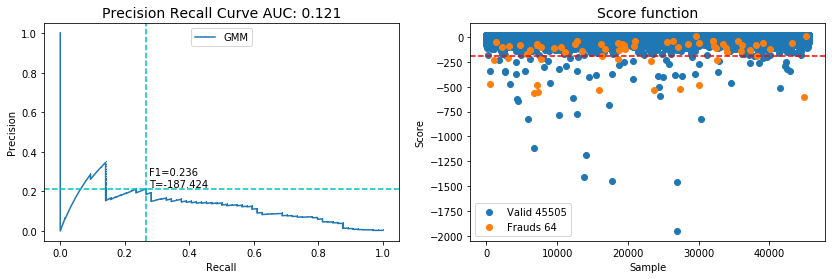

In [21]:
plot_recall_precision_curve_samples_scores(clf=clf, X=X, y=y, clf_name='GMM')

It is very difficult to detect fraud transaction because in addition to severe class imbalance there is also severe class overlap. Fraud transactions are mixed with the valid ones in thier log likelihood score. It is important to tight our Gaussian model estimators to better fit with the data. we will do it via steps 2 in our algorithm and evaluate how better our Gussian for detecting anomalies.  
following results:

#### step 2:

In [22]:
%%time
clf, recalls, precisions = iterative_clf(clf=clf, X=X, y=y, clfs_equal_func=gmms_equal, n_iter=20)

Wall time: 1min 41s


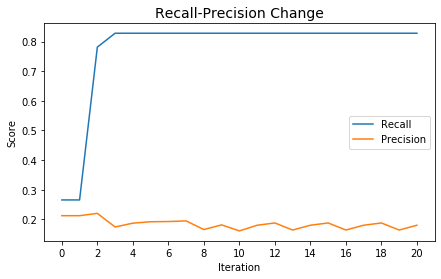

In [23]:
plot_recall_precision_change(recalls=recalls, precisions=precisions)

We can observe that recall is incresing until converged to constant ~0.8 while precision switching between lower and upper bounds with a small slice. This is importent beacuse overall we do not harm our model preformance in each iteration. also our model did not converged after 20 iterations, it may can be improved by setting converges with tolerance.  

Now we have our final model and we can select new threshold $T$ with respect to precision-recall trade-off.

#### Evaluate our final model 

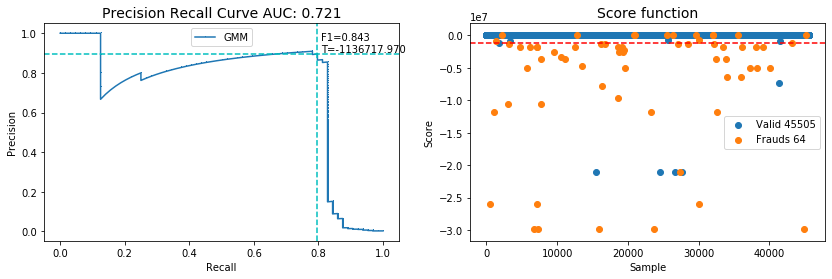

In [24]:
precisions, recalls, f1_scores, thresholds = get_curve_metrics(clf, X, y)
t, p, r, f1 = f1_max_threshold(precisions, recalls, f1_scores, thresholds)
plot_recall_precision_curve_samples_scores(clf=clf, X=X, y=y, clf_name='GMM')

Now it much more easy to detect frauds transactions based on log likelihood function. lower log likelihood function are indeed anomaly transactions. We can conclude that our Gaussian estimators are more fitted to vaild transactions while we didn't fit the model only with valid transactions! 

#### Evaluate test set

Testing our model with test set we achive the following result: 

In [25]:
x_test_evalute_report(clf=clf, X_test=X_test, y_test=y_test, threshold=t)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11374
           1       0.82      0.78      0.80        18

    accuracy                           1.00     11392
   macro avg       0.91      0.89      0.90     11392
weighted avg       1.00      1.00      1.00     11392



### One Class SVM

#### One Class SVM Parameters
 - **nu**: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. it is recommended​ to take nu near to the noise class, in our case frauds. we have imbalace data so we will set nu  to 0.01 which is 1%. 
 - **gamma**: Kernel coefficient, gamma='scale' is 1 / (n_features * X.var())
 - **kernel**: RBF kernel functions selected they are should be good enough with our Gaussian distributed data.

### Our Anomaly detection using Iterative OneClassSvm algorithm:
- $X$ - Dataset  
- $nu$ - 0.01  
- $\Gamma$ - $\frac{1}{(dim(X) * X.var())}$  
- $Kernel$ type - RBF  
- $I$ - number of iterations  


1. $C1$ = OneClassSVM($Kernel$, $nu$, $\Gamma$).fit($X$)  
2. for $i$ in $range(I)$:
 1. Initialize $F = \emptyset$   
 2. $\theta = C1.supportvectors_, C1.dualcoef$   
 3. Compute $\ell(s|\theta), s \in X$  
 4. $F$ = $\{s \in X \ |\ \ell(s|\theta) <= T\}$ $F$ is suspected anomalies list 
 5. $C2$ = OneClassSVM($Kernel$, $nu$, $\Gamma$).fit($X-F$)  
 6. If $C1$ == $C2$ call model converged and return $C2$  
   else $C1$=$C2$ and return to step 2 

#### Step 1

In [26]:
%%time
clf2 = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale')
clf2.fit(X)

Wall time: 3.25 s


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

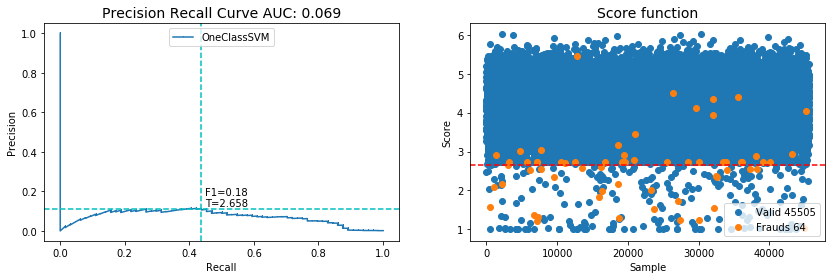

In [27]:
plot_recall_precision_curve_samples_scores(clf=clf2, X=X, y=y, clf_name='OneClassSVM')

As we can see, OneClassSVM score function produced an area under the threshold $T$ that contain highly mixed area of valid and fraud transaction. Here also it is very difficult to detect anomalies transactions.
We will try to better fit the support vectors estimators with the iterative approch below.

#### Step 2:

In [28]:
%%time
clf2, recalls, precisions = iterative_clf(clf=clf2, X=X, y=y, clfs_equal_func=svms_equal, n_iter=50)

Wall time: 29.4 s


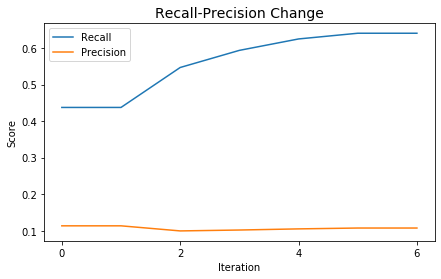

In [29]:
plot_recall_precision_change(recalls=recalls, precisions=precisions)

Unlike the Gaussian Model here we achived converged after the sixth iteration. We can observe that recall is incresing until converged to constant ~0.7 while precision stay constant with very low percentage ~0.1. Also here our iterative approch do not harm our model preformance in each iteration.

Now we have our final model and we can select new threshold  𝑇  with respect to precision-recall trade-off.

#### Evaluate our final model 

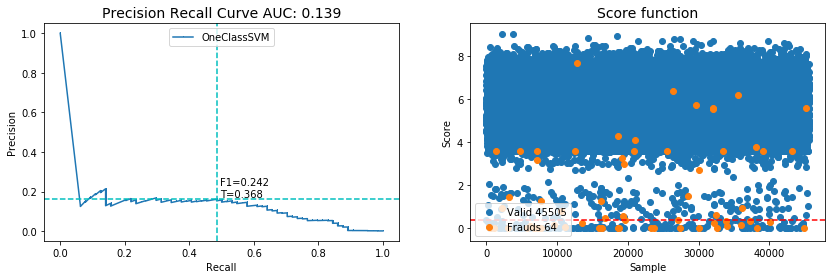

In [30]:
precisions, recalls, f1_scores, thresholds = get_curve_metrics(clf2, X, y)
t, p, r, f1 = f1_max_threshold(precisions, recalls, f1_scores, thresholds)
plot_recall_precision_curve_samples_scores(clf=clf2, X=X, y=y, clf_name='OneClassSVM')

We got beeter result from iteration 1 in terms of valid-frauds spread under the threshold $T$, recall seems to be increasing to acceptable value but precision keep low value.

#### Evaluate test set

In [31]:
x_test_evalute_report(clf=clf2, X_test=X_test, y_test=y_test, threshold=t)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11374
           1       0.20      0.61      0.30        18

    accuracy                           1.00     11392
   macro avg       0.60      0.80      0.65     11392
weighted avg       1.00      1.00      1.00     11392



### Conclusion
In this paper we propose a method that identifying outliers and pure inliers by assigning a score to each data point in highly imbalanced dataset. The proposed method assumes no prior knowledge of either the outliers or inliers.  We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.
First, we analyze our data with Gaussian Mixture Models to achieve threshold number one, we iterate our Gaussian Mixture Models till converge in order to accomplish a better threshold. We showed that area under the precision recall curve is getting better an better in each step and achieves the best F1 score in the end. In addition we showed the efficacy of our method on real world credit card fraud detection dataset. The model final classifier are:
- Precision = 82%
- Recall = 78%
- F1 score = 84%

Second, we followed the process above with OneClassSVM model. The model final classifier are:
- Precision = 20%
- Recall = 61%
- F1 score = 24%

Therefore, the values obtained from model use Gaussian Mixture are very satisfying, Especially when taking into consideration that we did not performed any pre-selection on the features and/or the class.